# Objetivo

En esta práctica nos encontramos ante un problema de clasificación: vamos a obtener una variable categórica como respuesta. Para este ejercicio obtendremos los datos de **Canadian Car Accidents 1994-2014**.

- ¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son más propensos a tener accidentes (acción correctiva en prima)?
- ¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son menos propensos a tener accidentes (descuento en prima)?
- ¿Qué es lo que más contribuye a que existan fallecimientos en un accidente?
- Dado un accidente, ¿se puede generar un modelo que prediga si habrá fallecimientos o no? ¿Si se va a necesitar tratamiento médico o no? Las aseguradoras tienen que inmovilizar capital para pagar estas casuísticas.
- Libertad para generar análisis de valor y nuevas ideas. Se debe atacar mínimo un modelo (estimar si habrá fallecidos o no). Hecho esto, se puede plantear de forma opcional otros alcances (libertad para plantear opciones).
- Plus: complementar con datos abiertos de clima (aunque Canadá es muy grande) y de otra tipología, ¿hay algún tipo de relación con temperaturas medias, precipitación media del día/mes, nieve...? ¿a más días festivos o de vacaciones, más accidentes? etc.


Each feature is 100% categorical data, with some features having 2 categories, while others can have 30+. The data is not completely imputed appropriately (you can thank Stats Canada), so some data preprocessing is required. For instance, categories may have duplicates in the form of '01' and '1', or some data may be formatted as integers while others are formatted as strings. Some data is not known and is marked accordingly in 'drivingLegend.pdf'. Unfortunately, features such as location and impaired driving are not a part of this feature set, however there are plenty of others to work with.

**Hay que quitar valores raros, analizar dataset, quitar columnas no importantes etc**

In [1]:
# Importamos las librerías a utilizar
import pandas as pd
import warnings
from sklearn.metrics import confusion_matrix
from  sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')

In [2]:
db = pd.read_csv("NCDB_1999_to_2014.csv")

In [3]:
db

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,1999,1,1,20,2,02,34,UU,1,5,...,01,06,1990,01,M,41,11,1,UU,1
1,1999,1,1,20,2,02,34,UU,1,5,...,02,01,1987,01,M,19,11,1,UU,1
2,1999,1,1,20,2,02,34,UU,1,5,...,02,01,1987,02,F,20,13,2,02,2
3,1999,1,1,08,2,01,01,UU,5,3,...,01,01,1986,01,M,46,11,1,UU,1
4,1999,1,1,08,2,01,01,UU,5,3,...,99,NN,NNNN,01,M,05,99,2,UU,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860400,2014,UU,U,UU,2,UU,UU,01,U,U,...,13,07,UUUU,01,M,24,11,1,NN,1
5860401,2014,UU,U,23,2,01,06,05,1,1,...,1,14,2006,01,M,29,96,2,09,5
5860402,2014,UU,U,14,2,01,02,01,1,5,...,1,01,2006,01,F,UU,11,2,01,1
5860403,2014,UU,U,22,1,01,06,01,2,4,...,1,22,UUUU,01,M,67,12,3,01,U


In [4]:
db.columns

Index(['C_YEAR', 'C_MNTH', 'C_WDAY', 'C_HOUR', 'C_SEV', 'C_VEHS', 'C_CONF',
       'C_RCFG', 'C_WTHR', 'C_RSUR', 'C_RALN', 'C_TRAF', 'V_ID', 'V_TYPE',
       'V_YEAR', 'P_ID', 'P_SEX', 'P_AGE', 'P_PSN', 'P_ISEV', 'P_SAFE',
       'P_USER'],
      dtype='object')

- 'C_YEAR': Year,
- 'C_MNTH': Month, 
- 'C_WDAY': Day of week, 
- 'C_HOUR': Collision hour, 
- 'C_SEV': Collision severity, 
- 'C_VEHS': Number of vehicles involved in collision, 
- 'C_CONF': Collision configuration,
- 'C_RCFG': Roadway configuration, 
- 'C_WTHR': Weather condition, 
- 'C_RSUR': Road surface, 
- 'C_RALN': Road alignment, 
- 'C_TRAF': Traffic control, 
- 'V_ID': Vehicle sequence number, 
- 'V_TYPE': Vehicle type,
- 'V_YEAR': Vehicle model year, 
- 'P_ID': Person sequence number, 
- 'P_SEX': Person sex, 
- 'P_AGE': Person age, 
- 'P_PSN': Person position, 
- 'P_ISEV': Medical treatment required, 
- 'P_SAFE': Safety device used,
- 'P_USER': Road user class

In general: *UU/U: Unknown; XX/X: Jurisdiction does not provide this data; QQ/Q: Choice is other than the preceding values; NN: data element nos applicable*

Vemos que la información se compone de las personas relacionadas con el accidente: edad, género, vehículo que conduce, datos de su accidente.

In [5]:
db.dtypes

C_YEAR     int64
C_MNTH    object
C_WDAY    object
C_HOUR    object
C_SEV      int64
C_VEHS    object
C_CONF    object
C_RCFG    object
C_WTHR    object
C_RSUR    object
C_RALN    object
C_TRAF    object
V_ID      object
V_TYPE    object
V_YEAR    object
P_ID      object
P_SEX     object
P_AGE     object
P_PSN     object
P_ISEV    object
P_SAFE    object
P_USER    object
dtype: object

El hecho de que existan variables no conocidas (U), no especificadas (X), no definida (Q) causa que la mayoría de las variables sean de tipo object, a pesar de estar mayoritariamente compuesta por números.

In [59]:
#diferenciamos numéricas de categóricas
numerical_var = (db.dtypes[db.dtypes!='object'].index.to_list())
categorical_var = (db.dtypes[db.dtypes=='object'].index.to_list())

print('Variables numéricas ', numerical_var)
print('Variables categóricas: ', categorical_var)

Variables numéricas  ['C_YEAR', 'C_SEV']
Variables categóricas:  ['C_MNTH', 'C_WDAY', 'C_HOUR', 'C_VEHS', 'C_CONF', 'C_RCFG', 'C_WTHR', 'C_RSUR', 'C_RALN', 'C_TRAF', 'V_ID', 'V_TYPE', 'V_YEAR', 'P_ID', 'P_SEX', 'P_AGE', 'P_PSN', 'P_ISEV', 'P_SAFE', 'P_USER']


In [60]:
# Valores sin información: cambiar
cambio_Q = ['Q', 'QQ', 'QQQQ']
cambio_N = ['N', 'NN', 'NNNN']
cambio_U = ['U', 'UU', 'UUUU']
cambio_X = ['X', 'XX', 'XXXX']

In [61]:
db[categorical_var] = db[categorical_var].replace(cambio_Q, 0)
db[categorical_var] = db[categorical_var].replace(cambio_N, 0)
db[categorical_var] = db[categorical_var].replace(cambio_U, 0)
db[categorical_var] = db[categorical_var].replace(cambio_X, 0)

In [85]:
db.isnull().sum().sort_values(ascending = False).head()

C_VEHS    3
C_YEAR    0
V_ID      0
P_SAFE    0
P_ISEV    0
dtype: int64

In [94]:
db2 = db.dropna()

In [97]:
db2

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,1999,1,1,20,2,02,34,0,1,5,...,01,06,1990,01,M,41,11,1,0,1
1,1999,1,1,20,2,02,34,0,1,5,...,02,01,1987,01,M,19,11,1,0,1
2,1999,1,1,20,2,02,34,0,1,5,...,02,01,1987,02,F,20,13,2,02,2
3,1999,1,1,08,2,01,01,0,5,3,...,01,01,1986,01,M,46,11,1,0,1
4,1999,1,1,08,2,01,01,0,5,3,...,99,0,0,01,M,05,99,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860400,2014,0,0,0,2,0,0,01,0,0,...,13,07,0,01,M,24,11,1,0,1
5860401,2014,0,0,23,2,01,06,05,1,1,...,1,14,2006,01,M,29,96,2,09,5
5860402,2014,0,0,14,2,01,02,01,1,5,...,1,01,2006,01,F,0,11,2,01,1
5860403,2014,0,0,22,1,01,06,01,2,4,...,1,22,0,01,M,67,12,3,01,0


### ¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son más propensos a tener accidentes (acción correctiva en prima)? 
### ¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son menos propensos a tener accidentes (descuento en prima)?

Para saber que vehículos y conductores son más (o menos) propensos a tener accidentes tendremos que filtrar la variable **P_PSN** *Person position* a 11 (*Driver* - Conductor). Esto también reducirá el número de vehículos pero consideramos que esto es adecuado ya que en esta base de datos el mismo vehículo puede aparecer más veces para el mismo accidente (más de una persona involucrada), por lo que los coches más propensos a tener accidentes no serían completamente precisos.

In [62]:
prueba = db

In [63]:
# Quitar comillas al 11 cuando en un ejercicio anterior hayamos cambiado P_PSN a numeric
pruebafilt = prueba[prueba['P_PSN'] == "11"]  

In [64]:
pruebafilt

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,1999,1,1,20,2,02,34,0,1,5,...,01,06,1990,01,M,41,11,1,0,1
1,1999,1,1,20,2,02,34,0,1,5,...,02,01,1987,01,M,19,11,1,0,1
3,1999,1,1,08,2,01,01,0,5,3,...,01,01,1986,01,M,46,11,1,0,1
5,1999,1,1,17,2,03,0,0,1,2,...,01,01,1984,01,M,28,11,1,0,1
6,1999,1,1,17,2,03,0,0,1,2,...,02,01,1991,01,M,21,11,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860397,2014,0,0,0,2,0,0,01,0,0,...,10,01,0,01,F,79,11,1,0,1
5860398,2014,0,0,0,2,0,0,01,0,0,...,11,01,0,01,F,20,11,1,0,1
5860399,2014,0,0,0,2,0,0,01,0,0,...,12,01,0,01,F,47,11,1,0,1
5860400,2014,0,0,0,2,0,0,01,0,0,...,13,07,0,01,M,24,11,1,0,1


Datos de personas:
'P_ID': Person sequence number,
'P_SEX': Person sex,
'P_AGE': Person age

In [65]:
pruebafilt["P_ID"].value_counts().head()

01    3899480
02      19728
03       4312
04       1528
05        570
Name: P_ID, dtype: int64

In [66]:
pruebafilt['P_SEX'].value_counts()

M    2355082
F    1413370
0     157634
Name: P_SEX, dtype: int64

M    2355082
F    1413370
0     157634
Name: P_SEX, dtype: int64


<AxesSubplot:title={'center':'Accidentes por género'}>

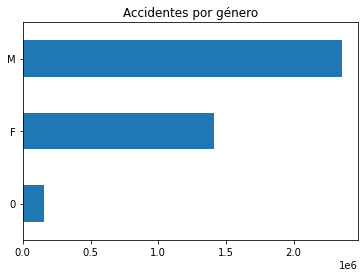

In [67]:
elimsex = pruebafilt[pruebafilt['P_SEX'] != "U"] 
elimsex = elimsex[elimsex['P_SEX'] != "N"]  
print(elimsex['P_SEX'].value_counts())
elimsex['P_SEX'].value_counts().sort_values().plot(kind = 'barh', title="Accidentes por género")

In [68]:
pruebafilt['P_AGE'].value_counts().head()

0     209207
19    106282
18    105127
20    103124
21     99183
Name: P_AGE, dtype: int64

0     209207
19    106282
18    105127
20    103124
21     99183
       ...  
03        72
96        67
02        66
98        40
97        26
Name: P_AGE, Length: 100, dtype: int64


<AxesSubplot:title={'center':'Accidentes por edad'}>

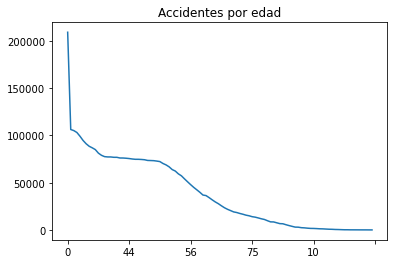

In [69]:
elimage = pruebafilt[pruebafilt['P_AGE'] != "UU"] 
elimage = elimage[elimage['P_AGE'] != "N"]  
print(elimage['P_AGE'].value_counts())
elimage['P_AGE'].value_counts().sort_values(ascending=False).plot(title="Accidentes por edad")

Datos de coches: 'V_ID': Vehicle sequence number,
'V_TYPE': Vehicle type,
'V_YEAR': Vehicle model year,

In [70]:
elim1 = pruebafilt[pruebafilt['V_TYPE'] != "UU"] 
elim1 = elim1[elim1['V_TYPE'] != "XX"]  
elim1 = elim1[elim1['V_TYPE'] != "NN"] 
elim1["V_TYPE"].replace({"QQ": "24"}, inplace=True)

In [71]:
elim1["V_TYPE"].value_counts()

01    3316715
06     122285
17     106822
14      94194
07      73832
08      63895
0       49989
05      45836
11      24862
09       7044
20       6627
16       5095
22       3092
23       1855
18       1739
19       1440
21        401
10        363
Name: V_TYPE, dtype: int64

01    3316715
06     122285
17     106822
14      94194
07      73832
08      63895
0       49989
05      45836
11      24862
09       7044
Name: V_TYPE, dtype: int64


<AxesSubplot:title={'center':'Accidentes por tipo de coche'}>

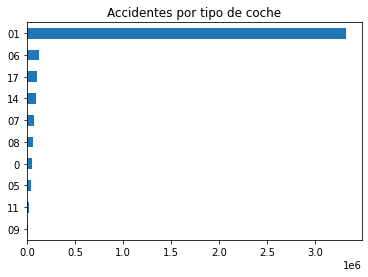

In [72]:
print(elim1["V_TYPE"].value_counts().head(10))
elim1["V_TYPE"].value_counts().head(10).sort_values().plot(kind = 'barh', title="Accidentes por tipo de coche")

Los automóviles que más accidentes tienen son los vehículos ligeros con diferencia (01). Probablemente porque son los más comunes y existen más cantidades de estos vehículos.

In [73]:
elim2 = pruebafilt[pruebafilt['V_YEAR'] != "UUUU"] 
elim2 = elim2[elim2['V_YEAR'] != "XXXX"]  
elim2 = elim2[elim2['V_YEAR'] != "NNNN"] 

0       299749
2000    222032
1998    202593
2002    201397
1999    198183
2003    192379
2001    192009
1997    180474
2005    156822
2004    154739
1995    154379
1996    135332
1994    133498
1992    131924
2006    131733
1993    128335
2007    127629
1991    115770
1990    108901
2008    101524
Name: V_YEAR, dtype: int64


<AxesSubplot:title={'center':'Accidentes por tipo de coche'}>

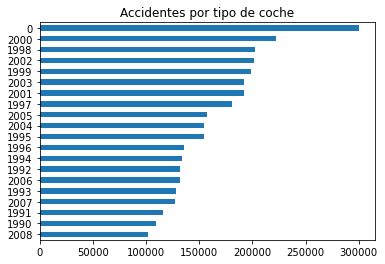

In [74]:
print(elim2["V_YEAR"].value_counts().head(20))
elim2["V_YEAR"].value_counts().head(20).sort_values().plot(kind = 'barh', title="Accidentes por tipo de coche")

2000    281609
2002    280588
1999    274553
2003    273889
2001    272937
2004    263265
2005    262902
2006    255964
2007    247854
2008    226611
2009    219567
2010    219117
2012    215717
2011    215373
2013    213800
2014    202340
Name: C_YEAR, dtype: int64


<AxesSubplot:title={'center':'Accidentes por año'}>

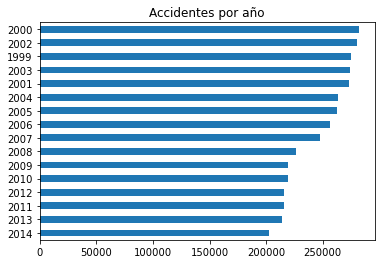

In [75]:
print(pruebafilt["C_YEAR"].value_counts().head(20))
pruebafilt["C_YEAR"].value_counts().head(20).sort_values().plot(kind = 'barh', title="Accidentes por año")

In [76]:
pruebafilt["V_YEAR"].value_counts().head()

0       299749
2000    222032
1998    202593
2002    201397
1999    198183
Name: V_YEAR, dtype: int64

### ¿Qué es lo que más contribuye a que existan fallecimientos en un accidente?

Variable P_ISEV

### Dado un accidente, ¿se puede generar un modelo que prediga si habrá fallecimientos o no? ¿Si se va a necesitar tratamiento médico o no? Las aseguradoras tienen que inmovilizar capital para pagar estas casuísticas.

Variable P_ISEV fatality; P_ISEV = 1 medical treatment.

### Libertad para generar análisis de valor y nuevas ideas. Se debe atacar mínimo un modelo (estimar si habrá fallecidos o no). Hecho esto, se puede plantear de forma opcional otros alcances (libertad para plantear opciones).

### Plus: complementar con datos abiertos de clima (aunque Canadá es muy grande) y de otra tipología, ¿hay algún tipo de relación con temperaturas medias, precipitación media del día/mes, nieve...? ¿a más días festivos o de vacaciones, más accidentes? etc.

C_WTHR

C_MNTH

C_RCFG?

P_SAFE?